In [52]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [53]:
import tensorflow as tf
print(tf.__version__)
print(pd.__version__)

1.12.0
0.23.4


In [54]:
# set variables 
main_folder = 'C://Users/karim/Desktop/'
images_folder = main_folder +'clean_AMLSdataset_mediumset/'

EXAMPLE_PIC = images_folder + '1.png'
#EXAMPLE_PIC = 'C://Users/karim/1.png'


TRAINING_SAMPLES = 660
VALIDATION_SAMPLES = 170
TEST_SAMPLES = 170
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 16
NUM_EPOCHS = 15

In [55]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('clean_attribute_list_mediumset.csv')
df_attr.set_index('file_name', inplace=True)
#df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(1000, 5)

In [56]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 hair_color
1 eyeglasses
2 smiling
3 young
4 human


smiling    1
young      1
human     -1
Name: 1.png, dtype: int64

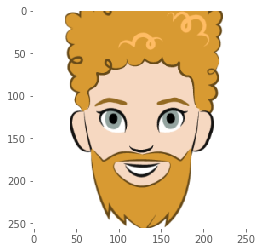

In [57]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['smiling','young','human']] #some attributes

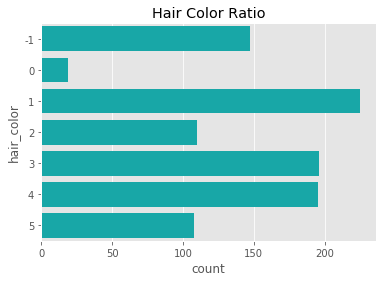

In [58]:
# Hair Color Ratio Display
plt.title('Hair Color Ratio')
sns.countplot(y='hair_color', data=df_attr, color="c")

plt.show()

In [59]:
df_partition = pd.read_csv('clean_list_eval_partition_mediumset.csv')
df_partition.head()

file_name  partition
0     1.png          0
1     2.png          0
2     3.png          0
3     7.png          0
4     8.png          0

In [60]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    660
1    170
2    170
Name: partition, dtype: int64

In [61]:
# join the partition with the attributes
df_partition.set_index('file_name', inplace=True)
df_par_attr = df_partition.join(df_attr['hair_color'], how='inner')
#df_par_attr.tail(100)
df_par_attr['hair_color'].value_counts().sort_index()

-1    147
 0     19
 1    225
 2    110
 3    196
 4    195
 5    108
Name: hair_color, dtype: int64

In [62]:
df_training = df_par_attr[(df_par_attr['partition'] == 0)] 
df_training['hair_color'].value_counts().sort_index()

-1     94
 0     11
 1    143
 2     69
 3    134
 4    137
 5     72
Name: hair_color, dtype: int64

In [63]:
df_training = df_par_attr[(df_par_attr['partition'] == 1)] 
df_training['hair_color'].value_counts().sort_index()

-1    23
 0     5
 1    49
 2    16
 3    32
 4    27
 5    18
Name: hair_color, dtype: int64

In [64]:
df_training = df_par_attr[(df_par_attr['partition'] == 2)] 
df_training['hair_color'].value_counts().sort_index()

-1    30
 0     3
 1    33
 2    25
 3    30
 4    31
 5    18
Name: hair_color, dtype: int64

In [65]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df_TRAIN(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    #BOLD PEOPLE
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(10))
    #BLOND HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(50))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 2)].sample(int(50))])
    #BROWN HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 3)].sample(int(50))])
    #BLACK HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 4)].sample(int(50))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 5)].sample(int(50))])
    
    #print(df_)
    
    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],6)

    return x_, y_

In [66]:
def generate_df_VAL(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
   #BOLD PEOPLE
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(5))
    #BLOND HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(10))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 2)].sample(int(10))])
    #BROWN HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 3)].sample(int(10))])
    #BLACK HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 4)].sample(int(10))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 5)].sample(int(10))])

    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],6)

    return x_, y_

In [67]:
def generate_df_TEST(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    #BOLD PEOPLE
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(3))
    #BLOND HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(10))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 2)].sample(int(10))])
    #BROWN HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 3)].sample(int(10))])
    #BLACK HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 4)].sample(int(10))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 5)].sample(int(10))])

    x_ = []
    y_ = []
        
    for index, target in df_.iterrows():
        im = cv2.imread(images_folder + index)
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        x_.append(im)
        y_.append(target[attr])

    return x_, y_

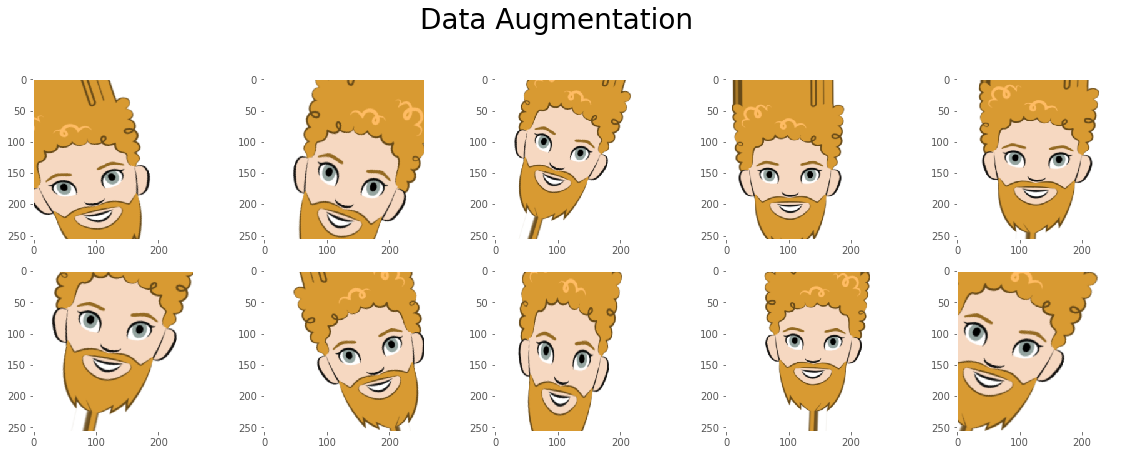

In [68]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(256, 256, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [69]:
# Train data
x_train, y_train = generate_df_TRAIN(0, 'hair_color', TRAINING_SAMPLES)

#print(x_train)
#print(y_train)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [70]:
# Validation Data
x_valid, y_valid = generate_df_VAL(1, 'hair_color', VALIDATION_SAMPLES)


In [71]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [72]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)

#CHOOSE 6 OUTPUTS AS WE HAVE 6 DIFFERENT CLASS ATTRIBUTES
predictions = Dense(6, activation="softmax")(x)

In [73]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [74]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.haircolordetectionfinal.hdf5', 
                               verbose=1, save_best_only=True)

In [75]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/15
42/41 [==============================] - 312s 7s/step - loss: 1.6645 - acc: 0.2949 - val_loss: 1.6874 - val_acc: 0.3636

Epoch 00001: val_loss improved from inf to 1.68742, saving model to weights.best.inc.haircolordetectionfinal.hdf5
Epoch 2/15
42/41 [==============================] - 291s 7s/step - loss: 1.3082 - acc: 0.5104 - val_loss: 1.4422 - val_acc: 0.5091

Epoch 00002: val_loss improved from 1.68742 to 1.44222, saving model to weights.best.inc.haircolordetectionfinal.hdf5
Epoch 3/15
42/41 [==============================] - 292s 7s/step - loss: 0.8767 - acc: 0.7055 - val_loss: 1.2406 - val_acc: 0.5818

Epoch 00003: val_loss improved from 1.44222 to 1.24062, saving model to weights.best.inc.haircolordetectionfinal.hdf5
Epoch 4/15
42/41 [==============================] - 299s 7s/step - loss: 0.6887 - acc: 0.7322 - val_loss: 0.9139 - val_acc: 0.6545

Epoch 00004: val_loss improved from 1.24062 to 0.91391, saving model to weights.best.inc.haircolordetectionfinal.hdf5
Epoc

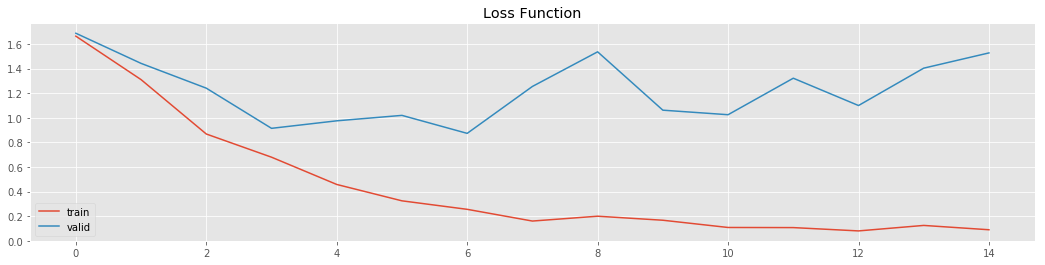

In [76]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

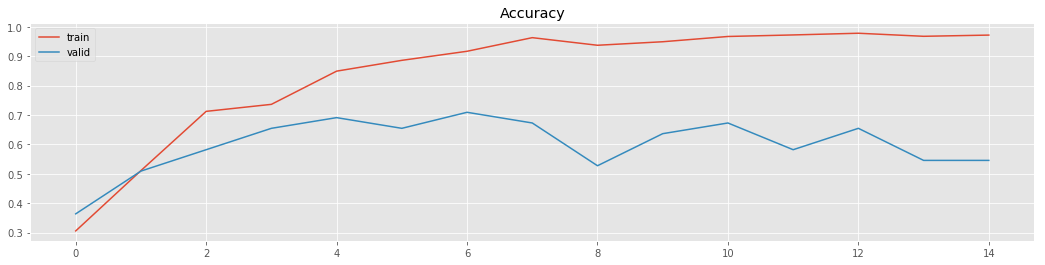

In [77]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [78]:
#load the best model
model_.load_weights('weights.best.inc.haircolordetectionfinal.hdf5')

In [79]:
# Test Data
x_test, y_test = generate_df_TEST(2, 'hair_color', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

print(model_predictions)

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions, average=None))

[2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 3, 3, 3, 3, 3, 4, 1, 4, 3, 3, 4, 4, 3, 4, 4, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Model Evaluation
Test accuracy: 75.4717%
f1_score: [0.5        0.8        0.76190476 0.52631579 0.70588235 1.        ]


In [85]:
#dictionary to name the prediction
attribute_target = {0: 'Bald'
                , 1: 'Blond'
                , 2: 'Ginger Hair'
                , 3: 'Brown Hair'
                , 4: 'Black Hair'
                , 5: 'Gray Hair'
                , -1: 'Noise'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    attribute = 'FIRST'
    attribute_icon = "https://i.imgur.com/nxWan2u.png"
    
    #print(prediction[1])
    #print(prediction)
    highest_prediction = max(prediction)
    #print(highest_prediction)
    
    
    if prediction[0] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Bald'
        
    if prediction[1] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Blond'
        
    if prediction[2] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Ginger Hair'
    if prediction[3] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Brown Hair'
    if prediction[4] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Black Hair'
    if prediction[5] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Gray Hair'
    
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: 5px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: 10px; font-size: 10px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: 25px; font-size: 10px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , attribute_icon
               , attribute
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , attribute_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [86]:
def attribute_prediction(filename):
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    

[0.03278846 0.06385077 0.0147703  0.39955822 0.41620594 0.0728263 ]
0.41620594



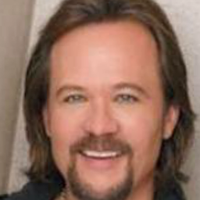

[8.3524344e-04 9.6430324e-02 8.9067197e-01 1.1264475e-02 1.9119696e-04
 6.0683570e-04]
0.89067197



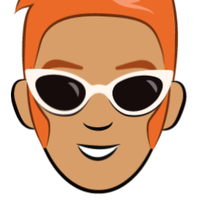

[0.0074916  0.06135502 0.03055814 0.8709885  0.02647664 0.00313006]
0.8709885



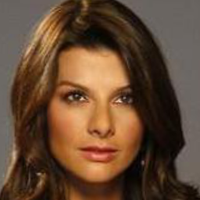

[0.00497028 0.15640208 0.00987405 0.0152959  0.00541787 0.80803984]
0.80803984



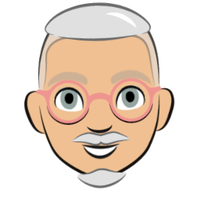

[0.057523   0.01609513 0.01151998 0.7060612  0.20607038 0.00273033]
0.7060612



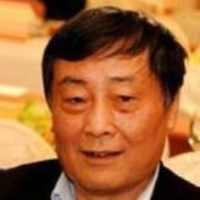

[0.00967905 0.05052503 0.01311949 0.42190927 0.07650763 0.42825952]
0.42825952



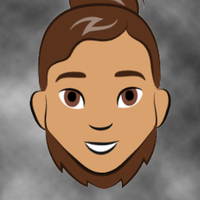

[0.04310665 0.61082655 0.1321469  0.08608007 0.0164233  0.11141643]
0.61082655



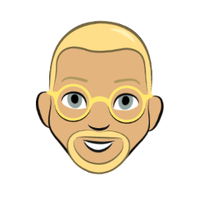

[2.5009080e-03 9.4209003e-01 4.6824314e-02 6.4893272e-03 9.4090879e-04
 1.1543895e-03]
0.94209003



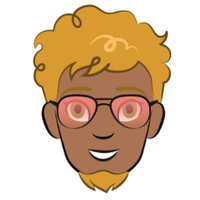

[1.8393489e-03 9.8221672e-01 1.3380387e-03 1.2607258e-02 3.9178849e-04
 1.6068129e-03]
0.9822167



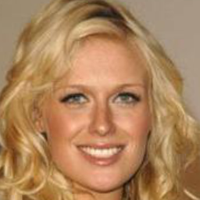

[0.01488758 0.17786044 0.03175759 0.6993093  0.07290118 0.00328391]
0.6993093



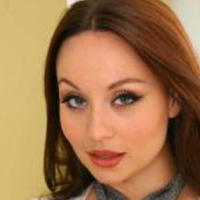

[0.00519339 0.00467035 0.00250779 0.06513599 0.9179963  0.00449615]
0.9179963



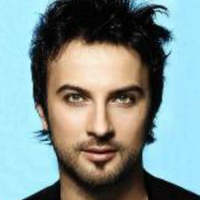

[0.01736961 0.02543161 0.01291785 0.9248537  0.01734329 0.00208392]
0.9248537



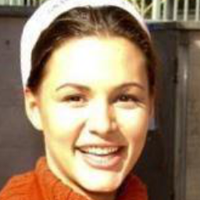

[0.01476738 0.74491656 0.00444419 0.21684314 0.00424535 0.01478328]
0.74491656



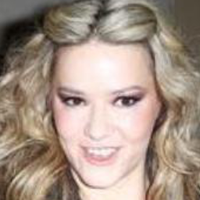

[0.01344257 0.24525046 0.503825   0.17790815 0.00269496 0.05687893]
0.503825



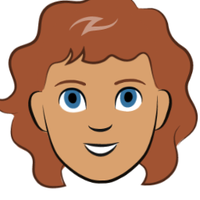

[0.03685708 0.02715843 0.06253495 0.23615877 0.1768838  0.460407  ]
0.460407



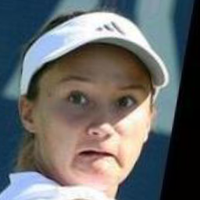

[1.5358687e-03 9.8380011e-01 2.4642122e-03 1.0665025e-02 3.7106810e-04
 1.1636462e-03]
0.9838001



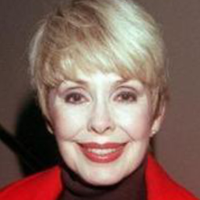

[0.01698119 0.12569784 0.01915098 0.8205145  0.00955434 0.00810115]
0.8205145



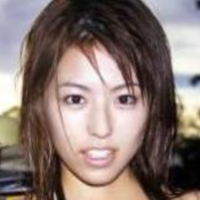

[0.02944197 0.26312178 0.00656357 0.6866839  0.01097601 0.00321284]
0.6866839



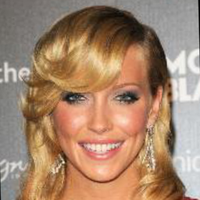

[1.7736995e-04 7.5111766e-03 3.1675055e-04 1.7878768e-04 4.9940788e-04
 9.9131656e-01]
0.99131656



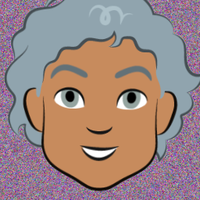

[0.00682307 0.01128609 0.49608847 0.479536   0.0026477  0.00361855]
0.49608847



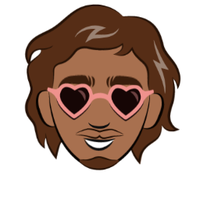

[9.3227718e-04 3.5700080e-01 6.3950980e-01 1.8167605e-03 1.9584886e-04
 5.4455665e-04]
0.6395098



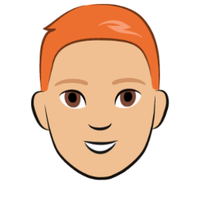

[0.01084771 0.02866346 0.02004525 0.0552345  0.6489477  0.23626147]
0.6489477



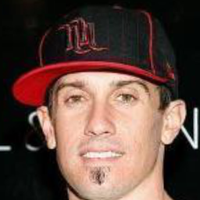

[0.00396774 0.01192559 0.09072515 0.8675953  0.0069284  0.01885786]
0.8675953



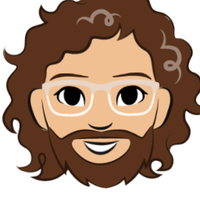

[0.00510914 0.18644466 0.40330696 0.3897223  0.00461425 0.0108027 ]
0.40330696



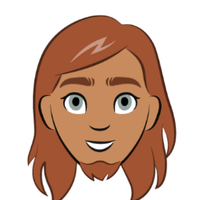

[0.00644455 0.85800475 0.07026794 0.02140622 0.00285191 0.04102451]
0.85800475



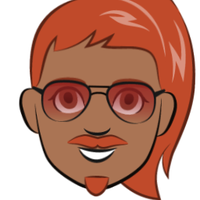

[1.9281132e-04 3.9950842e-03 1.3243188e-03 1.5612409e-03 3.6657774e-03
 9.8926079e-01]
0.9892608



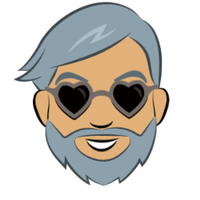

[0.024532   0.3824483  0.02459777 0.5159878  0.0369306  0.01550356]
0.5159878



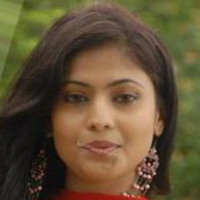

[0.01402804 0.8464835  0.01579636 0.10985155 0.00412449 0.00971605]
0.8464835



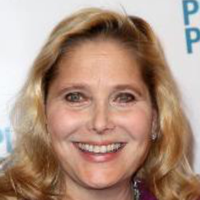

[0.870943   0.01374632 0.01356466 0.07306808 0.01838925 0.01028861]
0.870943



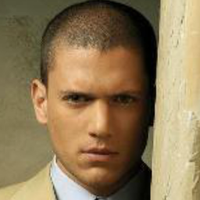

[0.01929139 0.27217335 0.32181686 0.37126815 0.00649634 0.00895386]
0.37126815



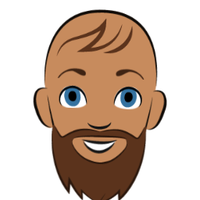

[8.5135782e-04 5.0038487e-01 4.8374361e-01 2.1679841e-03 4.4851340e-04
 1.2403748e-02]
0.50038487



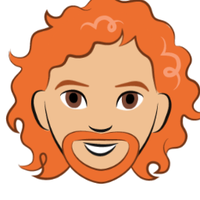

[7.2790222e-05 5.3062411e-03 9.9270868e-01 1.8334085e-03 2.8815393e-05
 5.0053619e-05]
0.9927087



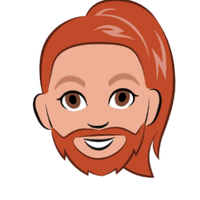

[8.2797837e-04 9.6067196e-01 2.7917862e-02 5.3910296e-03 1.8319790e-04
 5.0078579e-03]
0.96067196



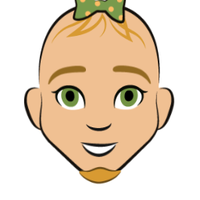

[0.0061259  0.00371196 0.01776252 0.9467798  0.02406953 0.00155026]
0.9467798



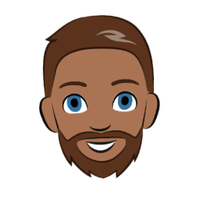

[0.07703197 0.18254742 0.00988717 0.29166338 0.05188835 0.38698167]
0.38698167



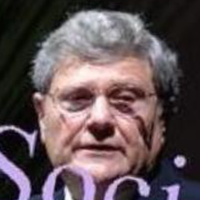

[1.0696398e-05 9.7319216e-04 1.3332153e-04 1.4814544e-04 2.2708667e-04
 9.9850756e-01]
0.99850756



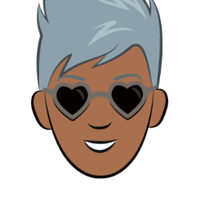

[5.4406683e-04 9.7213393e-01 1.2779208e-02 7.5876107e-04 2.8356386e-04
 1.3500450e-02]
0.97213393



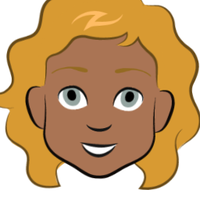

[0.01346089 0.01385077 0.04906885 0.6011826  0.22675323 0.09568365]
0.6011826



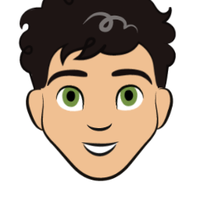

[0.0084041  0.01500409 0.01745827 0.18557929 0.07467373 0.6988805 ]
0.6988805



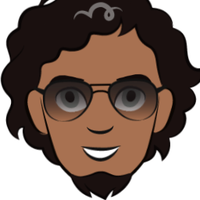

[0.01090461 0.00737786 0.02578612 0.37833703 0.5663125  0.01128186]
0.5663125



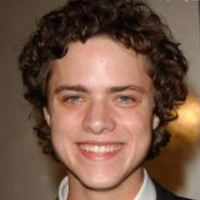

[6.5220334e-04 1.0127514e-01 8.8886666e-01 7.3762191e-03 4.6917881e-04
 1.3606313e-03]
0.88886666



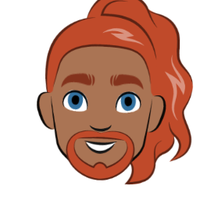

[0.01004547 0.7346505  0.10135269 0.07864181 0.00708308 0.06822645]
0.7346505



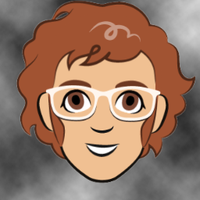

[0.00888707 0.05639338 0.07604232 0.1588177  0.01253088 0.68732864]
0.68732864



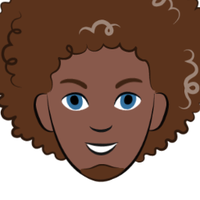

[0.00616027 0.9425145  0.00279388 0.03719812 0.00209882 0.00923448]
0.9425145



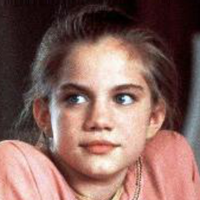

[0.00255976 0.00391553 0.00273955 0.95784193 0.02997694 0.00296627]
0.95784193



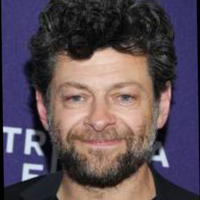

[0.01403073 0.0022252  0.00493139 0.48041266 0.4920968  0.00630318]
0.4920968



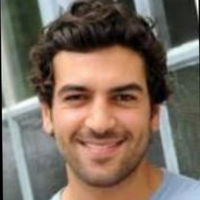

[0.00370798 0.0040156  0.03207631 0.9273868  0.01783836 0.01497485]
0.9273868



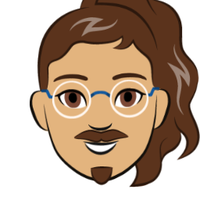

[0.04537128 0.09080877 0.06202664 0.70376176 0.08152873 0.01650284]
0.70376176



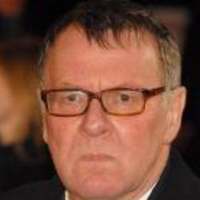

[1.0909796e-04 1.5057938e-03 3.1152886e-04 4.5019994e-04 7.0857001e-04
 9.9691474e-01]
0.99691474



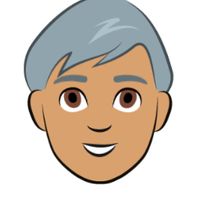

[0.05398727 0.5410773  0.01485943 0.3473317  0.01044817 0.03229612]
0.5410773



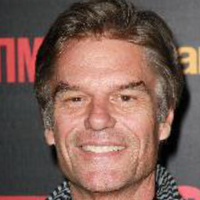

[9.8113751e-04 6.4960188e-01 3.4150714e-01 2.0121720e-03 2.8900709e-04
 5.6086755e-03]
0.6496019



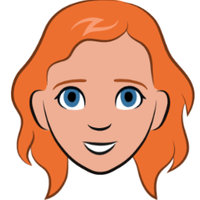

[0.01281859 0.30940834 0.01358949 0.6091731  0.03247019 0.02254033]
0.6091731



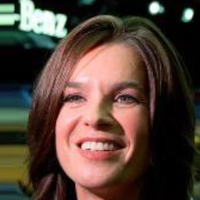

[0.00328802 0.00725529 0.02390757 0.95022273 0.01020616 0.00512023]
0.95022273



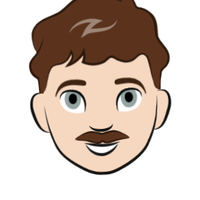

[0.00727996 0.01504554 0.00462342 0.95607305 0.0154132  0.00156482]
0.95607305



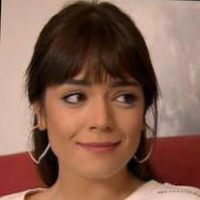

[0.00814932 0.01245325 0.01349747 0.05686816 0.32701045 0.5820213 ]
0.5820213



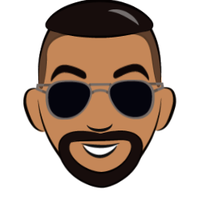

[2.4217396e-04 1.1086878e-02 9.8053586e-01 7.7949627e-03 1.6864824e-04
 1.7152852e-04]
0.98053586



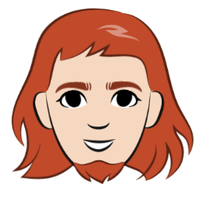

[6.7456195e-04 9.8669147e-01 4.9970266e-03 1.4844326e-03 1.2692297e-04
 6.0256594e-03]
0.9866915



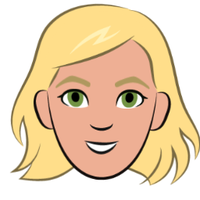

[0.18992826 0.74826556 0.00940747 0.02961907 0.00934415 0.01343533]
0.74826556



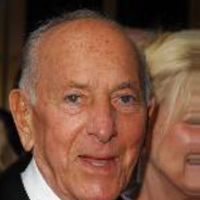

[2.9192789e-04 3.5966489e-02 9.6084177e-01 1.8426023e-03 1.3932049e-04
 9.1794389e-04]
0.9608418



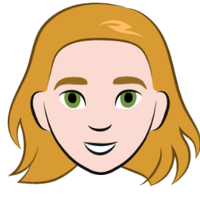

[0.01658571 0.01876391 0.0059862  0.940122   0.01493467 0.00360757]
0.940122



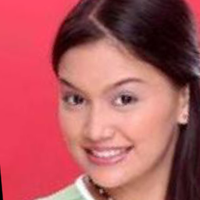

[0.01828371 0.0097885  0.01069279 0.47123802 0.419074   0.07092295]
0.47123802



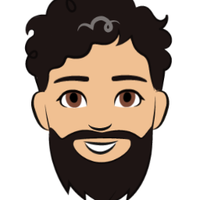

[0.00296947 0.04873604 0.00265885 0.01858747 0.01031099 0.91673714]
0.91673714



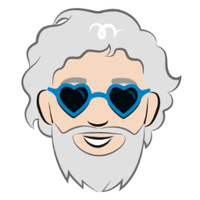

[2.0128192e-04 7.4192495e-03 9.8685503e-01 5.3565237e-03 9.8609285e-05
 6.9455702e-05]
0.98685503



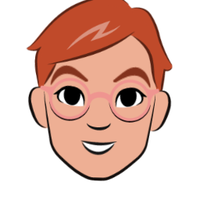

[0.06599367 0.461071   0.03399831 0.3675684  0.01957429 0.05179425]
0.461071



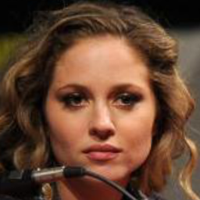

[0.01089666 0.5874319  0.02449553 0.37035567 0.00327399 0.00354621]
0.5874319



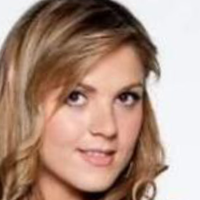

[0.02221039 0.00930899 0.0030099  0.5673479  0.3751322  0.02299061]
0.5673479



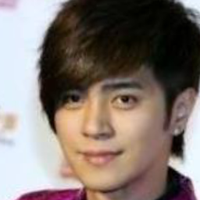

[0.09423871 0.03920728 0.3063429  0.3779278  0.1572919  0.02499141]
0.3779278



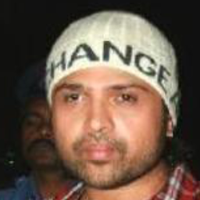

[5.8605650e-04 8.8025886e-01 1.1069448e-01 3.2749309e-03 1.5821631e-04
 5.0274087e-03]
0.88025886



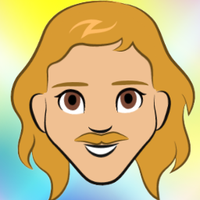

[0.00358339 0.9242431  0.04007302 0.01177161 0.00093976 0.01938927]
0.9242431



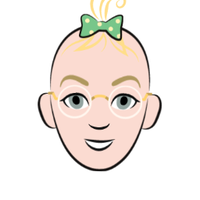

[0.00352622 0.02043117 0.00855004 0.01172805 0.00905508 0.94670945]
0.94670945



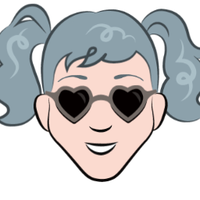

[9.6074364e-04 1.6421461e-02 9.7880965e-01 3.1378935e-03 2.8946649e-04
 3.8083710e-04]
0.97880965



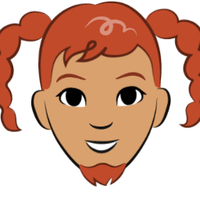

[1.9702637e-03 3.3439632e-04 9.9476764e-04 1.2364020e-02 9.8278552e-01
 1.5510934e-03]
0.9827855



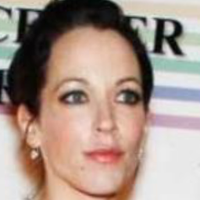

[0.00593951 0.14555924 0.04787523 0.5295347  0.05253229 0.21855901]
0.5295347



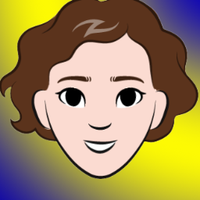

[2.0832808e-03 6.5996605e-03 9.0531921e-01 8.2942337e-02 5.8714434e-04
 2.4684728e-03]
0.9053192



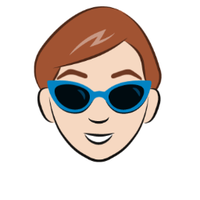

[1.9738125e-03 7.6738821e-04 3.7701850e-04 2.5633089e-02 9.6790779e-01
 3.3408902e-03]
0.9679078



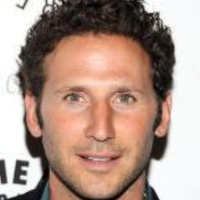

[0.01437662 0.40049827 0.0307156  0.5337362  0.01497518 0.0056981 ]
0.5337362



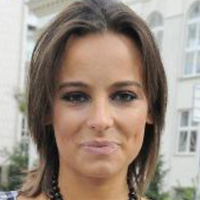

[0.01638871 0.0028393  0.00152763 0.07461618 0.892841   0.01178724]
0.892841



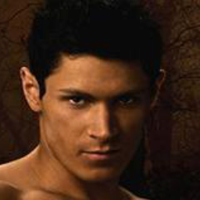

[0.00447825 0.00110133 0.00156291 0.00759989 0.9814053  0.00385233]
0.9814053



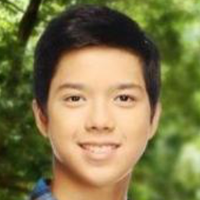

[1.7532409e-04 9.9596739e-01 1.5333403e-03 7.7699937e-05 6.1366729e-05
 2.1848441e-03]
0.9959674



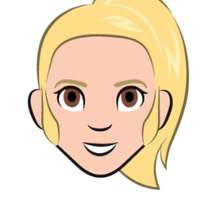

[0.00494842 0.75655466 0.07170584 0.02678599 0.00258587 0.13741904]
0.75655466



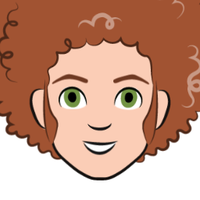

[1.1214924e-03 9.8215437e-01 9.3121035e-04 5.2839407e-04 4.9406238e-04
 1.4770502e-02]
0.98215437



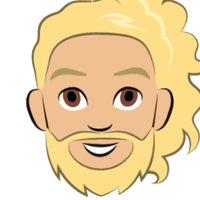

[0.02151412 0.08660619 0.01439003 0.464772   0.37240726 0.04031048]
0.464772



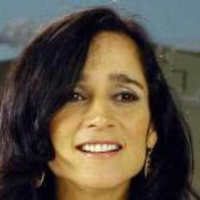

[4.3854842e-04 1.7897511e-01 8.1489295e-01 4.8432415e-03 1.6769653e-04
 6.8256207e-04]
0.81489295



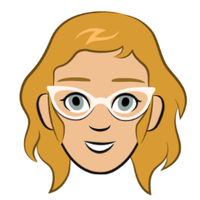

[0.00555618 0.887463   0.02684978 0.01045999 0.0011285  0.06854268]
0.887463



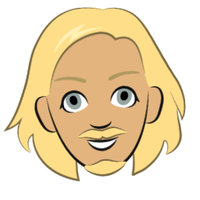

[0.00934687 0.01682919 0.02665875 0.4183135  0.3987663  0.13008536]
0.4183135



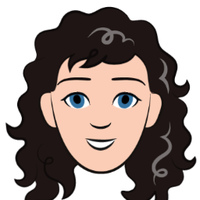

[0.01747447 0.5864209  0.01634024 0.3309     0.03555522 0.01330923]
0.5864209



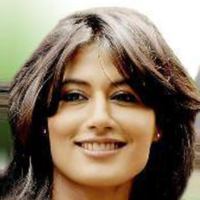

[0.03311999 0.3178735  0.0656869  0.5714698  0.0059186  0.00593119]
0.5714698



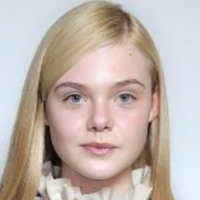

[0.00093728 0.01079494 0.62398326 0.36173254 0.00076422 0.00178767]
0.62398326



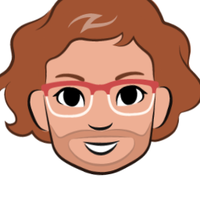

[0.01437423 0.0012463  0.00263328 0.02336388 0.9519156  0.00646677]
0.9519156



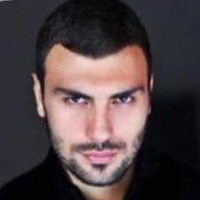

[0.00191195 0.19977404 0.00131763 0.01105862 0.00360709 0.7823307 ]
0.7823307



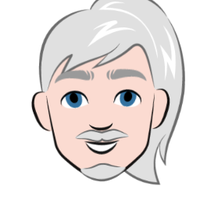

[0.0021418  0.03122547 0.62850094 0.32854944 0.00125196 0.00833043]
0.62850094



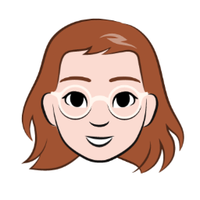

[0.09048274 0.01353988 0.09342404 0.58856237 0.20553407 0.00845688]
0.58856237



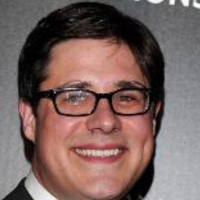

[3.2980910e-03 9.8373932e-01 1.6431045e-03 2.0948024e-03 7.1448495e-04
 8.5101360e-03]
0.9837393



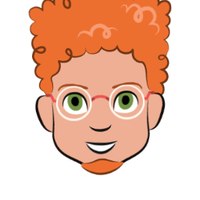

[0.00632691 0.39071572 0.0100978  0.58790326 0.00205562 0.00290063]
0.58790326



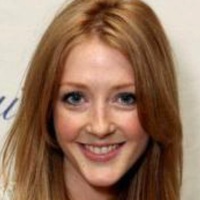

[1.06528995e-03 1.29191335e-02 7.15118251e-04 8.17749416e-04
 9.70533583e-03 9.74777341e-01]
0.97477734



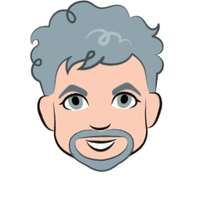

[0.00348341 0.0078084  0.02695593 0.9560324  0.00463241 0.00108741]
0.9560324



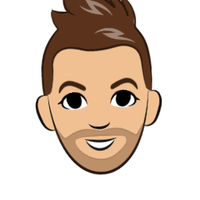

[1.6201916e-04 1.7739426e-02 1.1595740e-03 6.0717709e-04 6.3019549e-04
 9.7970164e-01]
0.97970164



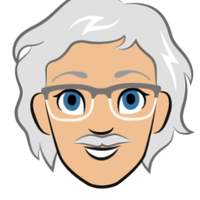

[1.6667771e-03 7.8950691e-01 2.0280400e-01 2.7330944e-03 5.9557607e-04
 2.6935781e-03]
0.7895069



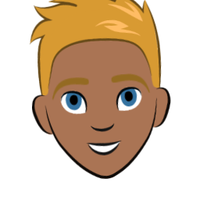

[0.01662897 0.4048642  0.01562573 0.2639045  0.06244167 0.236535  ]
0.4048642



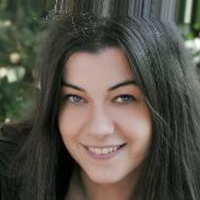

[1.5551343e-03 9.4592613e-01 4.8267916e-02 1.7926118e-03 2.3013190e-04
 2.2281010e-03]
0.94592613



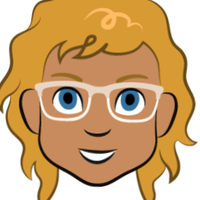

[0.01587974 0.13756402 0.00583442 0.8158346  0.01619243 0.00869482]
0.8158346



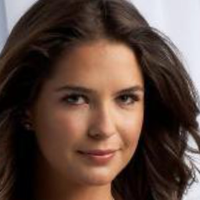

[0.00999848 0.06567694 0.70402944 0.20574558 0.00279782 0.01175179]
0.70402944



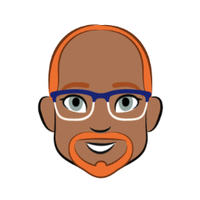

[0.00515495 0.00102126 0.00295701 0.18609734 0.78516936 0.01960007]
0.78516936



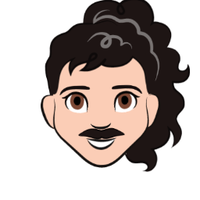

[0.6893642  0.10812776 0.03716793 0.11768951 0.02363981 0.02401079]
0.6893642



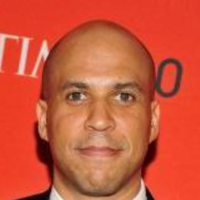

[0.00934606 0.00195113 0.00131819 0.028834   0.9266654  0.03188523]
0.9266654



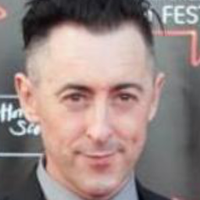

[0.00322177 0.9722302  0.00632398 0.00983084 0.00558949 0.00280374]
0.9722302



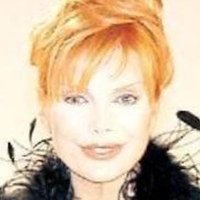

[0.01132059 0.00847785 0.0932413  0.4613255  0.17357162 0.25206316]
0.4613255



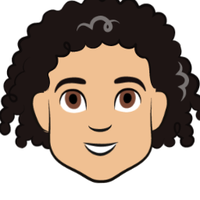

[0.00545934 0.8545733  0.00671422 0.10968669 0.00337317 0.02019306]
0.8545733



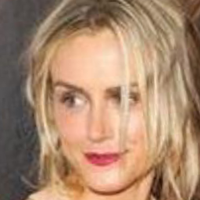

[1.1329855e-03 2.3959161e-04 3.6685387e-04 4.7392473e-03 9.9197364e-01
 1.5477055e-03]
0.99197364



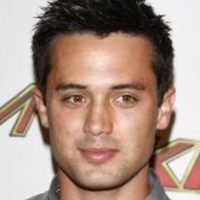

[0.00177767 0.7657593  0.16162895 0.02802428 0.0010806  0.04172912]
0.7657593



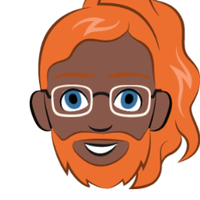

[0.05957471 0.01026843 0.01057859 0.3760176  0.4731152  0.07044546]
0.4731152



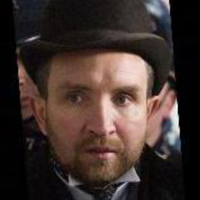

[4.04329447e-04 1.09008225e-02 1.02419907e-03 1.14390126e-03
 9.99879790e-04 9.85526919e-01]
0.9855269



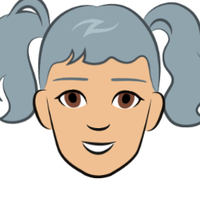

[0.01525079 0.03491208 0.0041713  0.11411266 0.23977467 0.5917785 ]
0.5917785



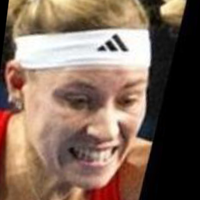

[0.06120955 0.0455478  0.01335454 0.10942808 0.60882    0.16163994]
0.60882



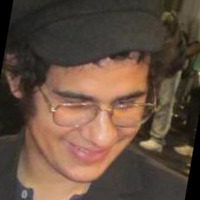

[2.6204262e-03 9.1157007e-01 3.4907293e-03 7.6658063e-02 7.0155843e-04
 4.9591912e-03]
0.9115701



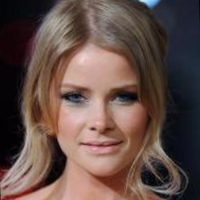

[2.3681142e-04 9.9763405e-01 7.9625251e-04 1.9441271e-04 1.5810844e-04
 9.8049233e-04]
0.99763405



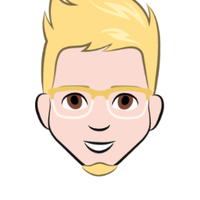

[0.01732957 0.3320506  0.5676543  0.06928441 0.0022701  0.01141108]
0.5676543



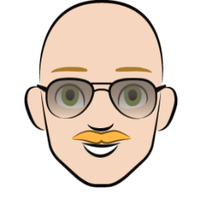

[0.00518467 0.00197819 0.00193418 0.04977676 0.93183243 0.00929382]
0.93183243



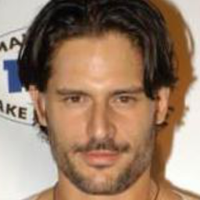

[0.00751762 0.00499398 0.00429812 0.5677258  0.4110935  0.00437102]
0.5677258



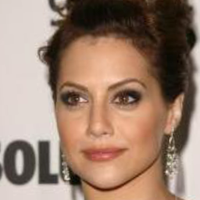

[0.00628997 0.03211524 0.69700265 0.25512728 0.00323501 0.00622987]
0.69700265



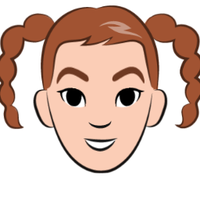

[0.00534423 0.04675114 0.00622467 0.02810208 0.00386893 0.9097089 ]
0.9097089



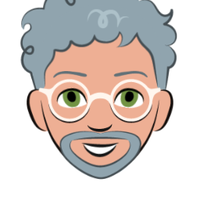

[0.00181549 0.4810335  0.5050304  0.00663211 0.00071616 0.00477244]
0.5050304



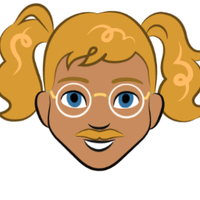

[3.3387245e-04 1.6726587e-02 1.2065663e-03 7.4752967e-04 1.3884248e-03
 9.7959703e-01]
0.97959703



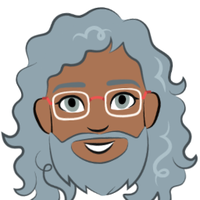

[0.11008818 0.1465359  0.02195535 0.6544763  0.03429075 0.03265345]
0.6544763



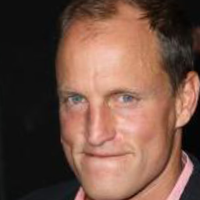

[1.0818455e-02 1.5473175e-02 3.8154447e-03 9.6358395e-01 5.3633028e-03
 9.4575284e-04]
0.96358395



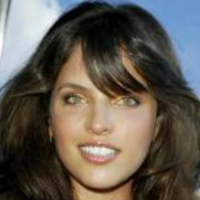

[9.2076021e-04 2.6918221e-02 9.6790934e-01 3.5188729e-03 1.6926919e-04
 5.6355685e-04]
0.96790934



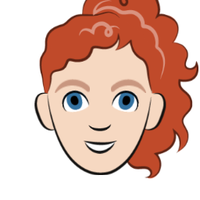

[3.4680765e-04 7.6616802e-03 9.8663843e-01 4.2025447e-03 3.7469072e-04
 7.7580026e-04]
0.9866384



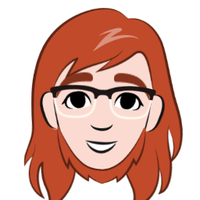

[4.8638138e-04 5.5541072e-02 9.4244844e-01 9.1602613e-04 1.1387845e-04
 4.9417064e-04]
0.94244844



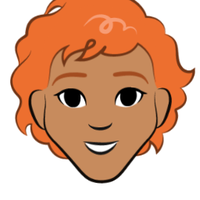

[8.9414808e-04 9.6738249e-01 1.3246486e-03 1.5710224e-03 2.3365521e-04
 2.8593991e-02]
0.9673825



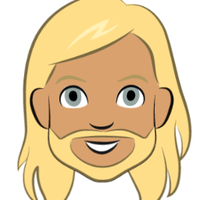

[0.00446696 0.00334264 0.00277684 0.02641475 0.9530122  0.00998653]
0.9530122



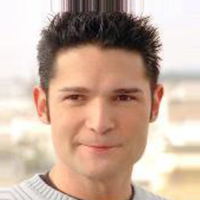

[7.7611278e-04 2.4945182e-01 7.4515641e-01 2.5502895e-03 5.5786804e-04
 1.5075171e-03]
0.7451564



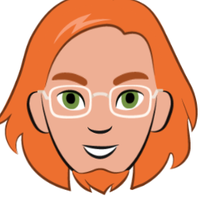

[0.02726545 0.07007541 0.03995921 0.6808927  0.1611594  0.02064787]
0.6808927



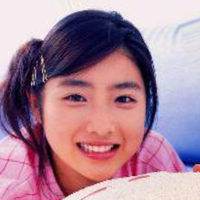

[0.01964288 0.40821856 0.01389385 0.5469835  0.00572609 0.00553509]
0.5469835



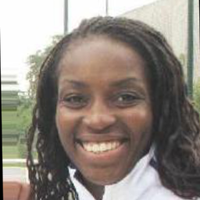

[1.9865055e-03 9.5037514e-01 3.4529693e-02 9.1616897e-04 5.7862891e-04
 1.1613829e-02]
0.95037514



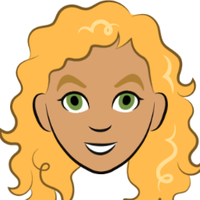

[0.02813795 0.5691632  0.28653002 0.04603221 0.00524019 0.06489641]
0.5691632



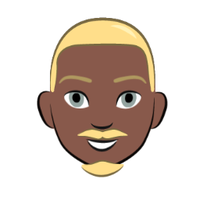

[0.00400163 0.56945974 0.4039508  0.01328165 0.00122985 0.00807636]
0.56945974



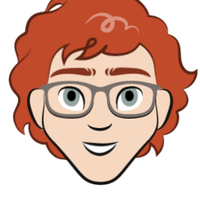

[0.02835058 0.7289823  0.15223901 0.04265508 0.00247036 0.04530266]
0.7289823



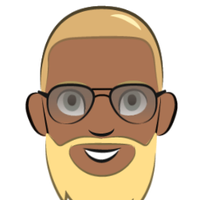

[1.3092416e-04 9.9706405e-01 2.2242614e-03 1.0568360e-04 4.1971893e-05
 4.3316121e-04]
0.99706405



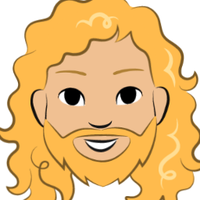

[0.00786165 0.0096137  0.0075669  0.01850654 0.8624985  0.0939527 ]
0.8624985



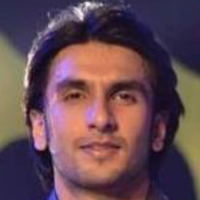

[0.00639219 0.01008232 0.05243508 0.9200226  0.00846976 0.00259804]
0.9200226



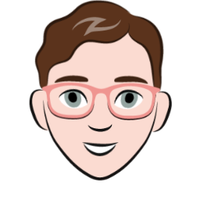

[3.0944441e-04 5.5154781e-03 9.9206299e-01 1.9554328e-03 6.1262886e-05
 9.5343079e-05]
0.992063



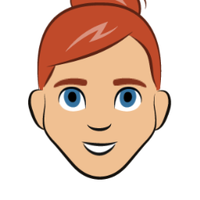

[0.01981635 0.0158728  0.18983805 0.6989797  0.00622556 0.06926756]
0.6989797



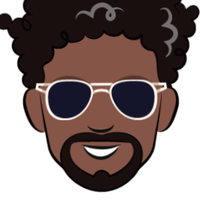

[8.0968934e-04 4.0925315e-01 5.8690047e-01 2.0961144e-03 2.0971321e-04
 7.3081453e-04]
0.5869005



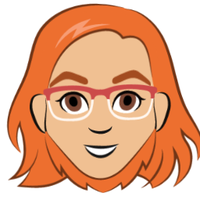

[5.7611116e-03 5.6188956e-02 8.8104289e-03 9.2774272e-01 1.2123210e-03
 2.8441712e-04]
0.9277427



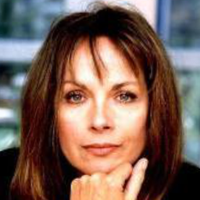

[1.2694220e-03 3.1415224e-02 9.5257425e-01 7.3075341e-03 9.3006465e-04
 6.5036160e-03]
0.95257425



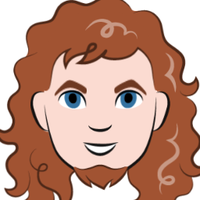

[0.01046884 0.02850711 0.00466963 0.94053257 0.01249452 0.00332728]
0.94053257



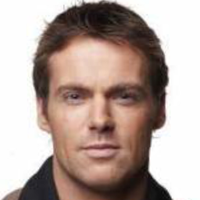

[0.00985002 0.00841374 0.02626417 0.26904166 0.68072474 0.00570564]
0.68072474



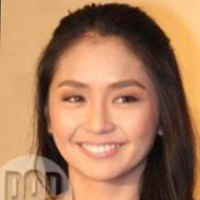

[2.9586211e-03 9.5070046e-01 4.2004012e-02 2.3803895e-03 3.3254267e-04
 1.6239000e-03]
0.95070046



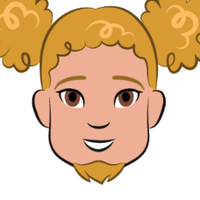

[1.7407606e-03 3.7779953e-04 3.2107919e-04 2.4771525e-03 9.7647786e-01
 1.8605284e-02]
0.97647786



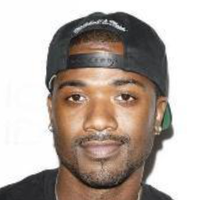

[0.0107909  0.00874632 0.02442387 0.3535966  0.5232736  0.07916871]
0.5232736



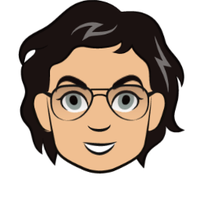

In [90]:
import csv

#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(150)

with open('task_5.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    filewriter.writerow([test_accuracy/100])
    
    for index, target in df_to_test.iterrows():
        result = attribute_prediction(images_folder + index)
        print(result[0])
        highest_pred= np.amax(result)
        print(highest_pred)

        pred_arr = result[0]
        #print(pred_arr[1])

        #display result
        display_result(images_folder + index, result[0], target['hair_color'])

        #print(index)

        if pred_arr[0] == highest_pred:
            number = int(0)
            filewriter.writerow([index, number])
        if pred_arr[1] == highest_pred:
            number = int(1)
            filewriter.writerow([index, number])
        if pred_arr[2] == highest_pred:
            number = int(2)
            filewriter.writerow([index, number])
        if pred_arr[3] == highest_pred:
            number = int(3)
            filewriter.writerow([index, number])
        if pred_arr[4] == highest_pred:
            number = int(4)
            filewriter.writerow([index, number])
        if pred_arr[5] == highest_pred:
            number = int(5)
            filewriter.writerow([index, number])